In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
import xarray as xr
import numpy as np
import os
import datetime
import shutil
import glob
import calendar
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tempfile
from PIL import Image

In [5]:
# List of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
ssh_data = '../datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
current_data = '../datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'

In [6]:

def plot_ssh_with_geostrophic_current_2(dat_path_1, dat_path_2, depth_level, var0, var1, var2, var3, unit, color):
    
    # Open the datasets
    data_1 = xr.open_dataset(dat_path_1)
    data_1 = data_1.sel(latitude=slice(2, 6.9))
    data_2 = xr.open_dataset(dat_path_2)
    data_2 = data_2.sel(latitude=slice(2, 6.9))

    # Resample SSH data and geostrophic currents
    monthly_ssh = data_1[var0].resample(time='1ME').mean()
    ds_depth = data_2.sel(depth=depth_level)
    ugos = ds_depth[var1].resample(time='1ME').mean()  # Eastward surface geostrophic current
    vgos = ds_depth[var2].resample(time='1ME').mean()  # Northward surface geostrophic current
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()})
    
    # Looping through each month
    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]

        # Select SSH data for the current month
        ssh_month = monthly_ssh.sel(time=monthly_ssh['time'].dt.month == (month_index + 1))

        # Reducing the dimensions to 2D (latitude, longitude) by averaging over the time dimension
        ssh_month_2d = ssh_month.mean(dim='time')

        # Plotting the SSH contours
        contour = ssh_month_2d.plot(ax=ax, cmap=color, add_colorbar=False)
        
        contour_lines = ax.contour(ssh_month_2d.longitude, ssh_month_2d.latitude, ssh_month_2d, levels=[0.375, 0.425], colors='black', linewidths=2)

        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='%0.2f')  
        

        latitudes = ugos.latitude[::5]  
        longitudes = ugos.longitude[::5] 
        
        ugos_selected = ugos.sel(longitude=longitudes, latitude=latitudes).mean(dim='time')  
        vgos_selected = vgos.sel(longitude=longitudes, latitude=latitudes).mean(dim='time')  
        
        # Plotting the geostrophic current vectors
        # ax.quiver(longitudes, latitudes, ugos_selected, vgos_selected, scale=5, color='red', width=0.003)

        ax.set_title(f'{month_names[month_index]}', fontsize=12)
        ax.coastlines(resolution='50m', color='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')  
        ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')  
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  
    fig.colorbar(contour, cax=cbar_ax, orientation='vertical', label=f'{var3} {unit}')
    
    plt.suptitle(f'Monthly {var3}', y=0.9, fontsize=14)
    
    plt.savefig(f'figures/{var3}.png')
    plt.show()

    data_1.close()
    data_2.close()




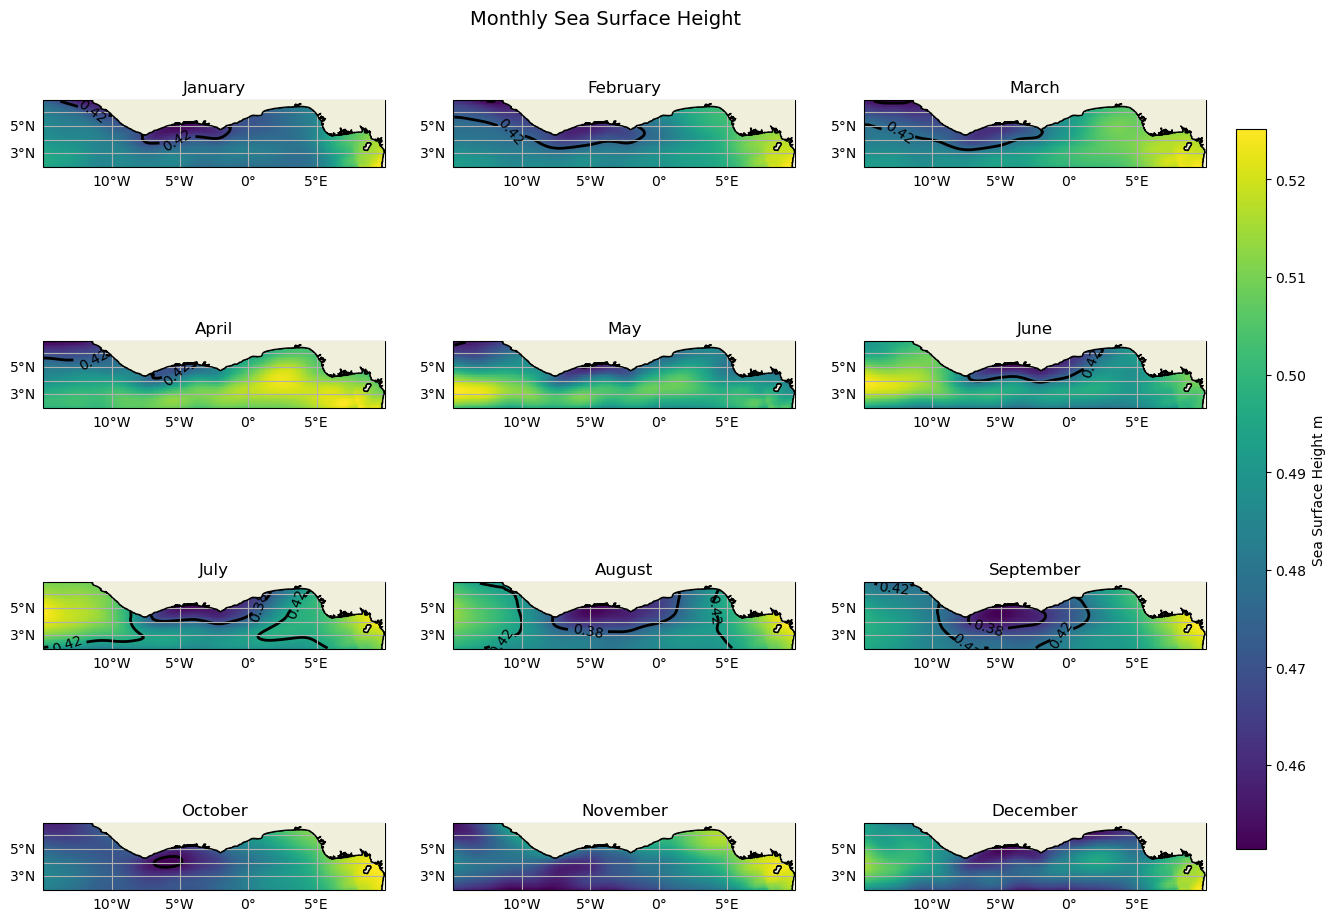

In [7]:
plot_ssh_with_geostrophic_current_2(ssh_data, current_data, 15, 'adt', 'ugos', 'vgos', 'Sea Surface Height',  'm', 'viridis')